In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re

import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-category-trainingdata/news_category_trainingdata.json


In [2]:
import os
# try:
#   import ktrain
# except:
#   !pip install ktrain
#   os.kill(os.getpid(), 9)
# import ktrain

from sklearn.model_selection import train_test_split
!pip install tf-keras
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))
os.environ['TF_USE_LEGACY_KERAS'] = '1'
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))

try:
  import ktrain
except:
  !pip install ktrain
  import ktrain
from ktrain import text
from ktrain.text import texts_from_df


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
TF_USE_LEGACY_KERAS: None
TF_USE_LEGACY_KERAS: 1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 40.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 39.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - do

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun 21 13:51:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              27W /  70W |    125MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 33.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
reviews = pd.read_json("/kaggle/input/news-category-trainingdata/news_category_trainingdata.json")

## EDA

In [6]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


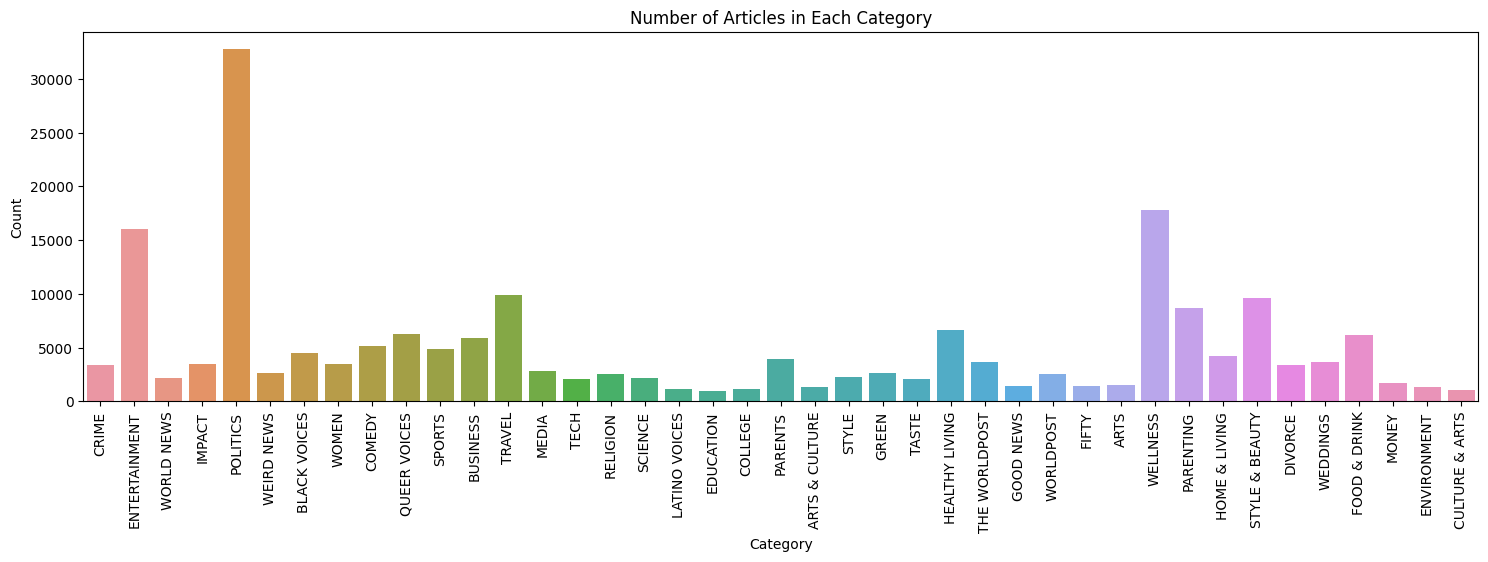

In [7]:
# reviews["category"].value_counts()
plt.figure().set_figwidth(18)
sns.countplot(x="category", data=reviews)
plt.title("Number of Articles in Each Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


## Prepare Data

In [9]:
reviews['combined_text'] = reviews['headline'].str.lower() + ' ' + reviews['short_description'].str.lower()

In [10]:
# healthy living and wellness articles
reviews[reviews["category"].str.contains("HEALTHY LIVING")].head()

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,to the people who say ‘i’m tired’ when someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,eating shake shack made me feel healthier than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,how to stay updated on the news without losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 perfect tweets about whole30 that will make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,the real reason your hands are always cold ess...


In [11]:
reviews[reviews["category"].str.contains("HEALTHY LIVING")].shape

(6694, 7)

In [12]:
# healthy living and wellness articles
reviews[reviews["category"].str.contains("WELLNESS")].head()

,category,headline,authors,link,short_description,date,combined_text
124989,WELLNESS,Why Overeating Doesn't Make You Fat,"Mark Hyman, MD, Contributor\nPracticing Physician",https://www.huffingtonpost.com/entry/overeatin...,If you take the right approach to ending your ...,2014-04-17,why overeating doesn't make you fat if you tak...
124990,WELLNESS,14 Habits Of People With A Healthy Relationshi...,Sarah Klein,https://www.huffingtonpost.com/entry/healthy-r...,After a long list of rules and habits like the...,2014-04-17,14 habits of people with a healthy relationshi...
124993,WELLNESS,5 Things That Could Be Stealing Your Joy,"Amanda Gore, Contributor\nInternational keynot...",https://www.huffingtonpost.com/entry/joy_us_5b...,Listen to yourself all day today -- are you an...,2014-04-17,5 things that could be stealing your joy liste...
124994,WELLNESS,Moments Make a Life,"Megan McDonough, Contributor\nCEO, Wholebeing ...",https://www.huffingtonpost.com/entry/moments-m...,Consciously constructing positive habits -- or...,2014-04-17,moments make a life consciously constructing p...
124996,WELLNESS,Fat Facts,"Maria Rodale, Contributor\nCEO and Chairman of...",https://www.huffingtonpost.com/entry/fat-facts...,"Human fat cells, photo by Dr. Peeke Here's how...",2014-04-17,"fat facts human fat cells, photo by dr. peeke ..."


In [13]:
reviews[reviews["category"].str.contains("WELLNESS")].shape

(17827, 7)

In [14]:
reviews["health_wellness"] = np.where((reviews["category"] == "HEALTHY LIVING") | (reviews["category"] == "WELLNESS"), 1, 0)

In [15]:
reviews["health_wellness"].value_counts()

health_wellness
0    176332
1     24521
Name: count, dtype: int64

In [16]:
target_names = ["NOT HEALTH WELLNESS", "HEALTH WELLNESS"]

## Balance the Data

In [17]:
sample_amount = 24000

health_wellness = reviews[reviews["health_wellness"] == 1].sample(n=sample_amount)
not_health_wellness = reviews[reviews["health_wellness"] == 0].sample(n=sample_amount)

In [18]:
review_sample = pd.concat([health_wellness, not_health_wellness])

In [19]:
review_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48000 entries, 132741 to 195437
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category           48000 non-null  object        
 1   headline           48000 non-null  object        
 2   authors            48000 non-null  object        
 3   link               48000 non-null  object        
 4   short_description  48000 non-null  object        
 5   date               48000 non-null  datetime64[ns]
 6   combined_text      48000 non-null  object        
 7   health_wellness    48000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 3.3+ MB


In [20]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [21]:
!pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

     \ 6.9 MB 17.6 MB/s 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=108160 sha256=7abba1fb5f8136a96b2b72c8f2512dc7b7d125d2da8196734eb184ba602294e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-7oa6k80n/wheels/0b/14/54/23c07f7254b733dc3daac99ba1fda60e30f1b2991b3b8ee0bf
Successfully built eli5
  Attempting uninstall: eli5
    Found existing installation: eli5 0.10.1
    Uninstalling eli5-0.10.1:
      Successfully uninstalled eli5-0.10.1


## Distilbert Model

['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
199822                  1.0              0.0
120850                  0.0              1.0
70521                   1.0              0.0
45474                   1.0              0.0
113652                  1.0              0.0
['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
55453                   1.0              0.0
104856                  1.0              0.0
178617                  0.0              1.0
161290                  0.0              1.0
153231                  0.0              1.0


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 69


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
2700/2700 [==============================] - 2417s 868ms/step - loss: 0.5029 - accuracy: 0.7817
Epoch 2/6
2700/2700 [==============================] - 2361s 870ms/step - loss: 0.2414 - accuracy: 0.9064
Epoch 3/6
2700/2700 [==============================] - 2357s 869ms/step - loss: 0.3809 - accuracy: 0.7910
Epoch 4/6
2700/2700 [==============================] - 1414s 520ms/step - loss: 0.8693 - accuracy: 0.5013


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


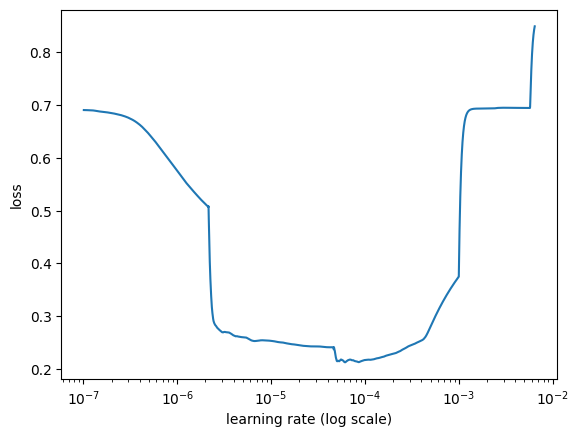



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
2700/2700 [==============================] - 2448s 892ms/step - loss: 0.2504 - accuracy: 0.9033 - val_loss: 0.2146 - val_accuracy: 0.9119
Epoch 2/10
2700/2700 [==============================] - 2399s 889ms/step - loss: 0.1552 - accuracy: 0.9433 - val_loss: 0.2315 - val_accuracy: 0.9146
Epoch 2: early stopping
Weights from best epoch have been loaded into model.
150/150 [==============================] - 53s 323ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2437
           1       0.90      0.92      0.91      2363

    accuracy                           0.91      4800
   macro avg       0.91      0.91      0.91      4800
weighted avg       0.91      0.91      0.91      4800



In [22]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["health_wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

learner.lr_find(max_epochs=6)

learner.lr_plot()

history=learner.autofit(
1e-4,
checkpoint_folder='checkpoint',
epochs=10,
early_stopping=True
)

predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

validation = learner.validate(val_data=val, print_report=True)

In [23]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.',
'What to Consider When Making Vacation Plans',
'The Best Destinations for a Digital Detox',
'I knew I wanted a tropical beach vacation. What I couldn’t have known was how a Mayan sacred-stone massage would somehow be more pampering, more life-affirming, and more of a body tune-up than a massage void of sacred Mayan stones.'
             ]

In [24]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability that this is health and wellness related is %s' % probs[1])
  print(text)

---------------------------
The probability that this is health and wellness related is 0.99354833
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability that this is health and wellness related is 0.98685455
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability that this is health and wellness related is 0.8555575
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability that this is health and wellness related is 0.9532836
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability

In [25]:
predictor.explain('I skeptically signed up for a family meditation session, which turned out to be one of the more incredible things we did on the trip: My colic-stricken four-month-old became uncharacteristically compliant and breastfed quietly for most of the session as our instructor methodically struck gongs and all manner of reverberating instruments, our bodies splayed out on the floor.')

In [26]:
test_docs = [
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.',
'Uptown is also, of course, home to some of the city\'s most iconic museums like the Met; and the relatively quieter city neighborhoods of the UES and UWS have an appreciated family-friend vibe.',
'Borough Market, the Tate Modern, and Southbank Centre are the main attractions but dig a little deeper to discover incredible food producers at Maltby Street Market and Spa Terminus in Bermondsey, off-the-beaten path foodie destinations in Peckham and Tooting, an idyllic country getaway at Petersham Nurseries, and a true cultural melting pot at the bars and shops of Brixton.',
'Dry brushing has become something of a mainstay in many beauty guru’s routines. Not only does it have a host of potential benefits, but it’s a moment of self-care, too—something everyone needs to set a little time aside for.',
'The nice thing about braids and other protective styles is that they help to make wash day a little more manageable.',
'Girl dinner is appealing on so many different levels. There’s no cooking involved, it’s relaxed and stress-free, it doesn’t take long to prepare, and it’s an excuse to indulge in foods that bring you joy.'
             ]

In [27]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is travel related is %s' % probs[1])
  print(text)

---------------------------
The probability this is travel related is 0.9532836
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is travel related is 0.0026828425
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.
---------------------------
The probability this is travel related is 0.0026704422
A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.
---------------------------
The probability this is travel related is 0.011288059
Uptown is also, of course, home to some of the city's most icon

In [28]:
predictor.explain('If you’re still printing out your boarding pass in 2024, trust me: There’s a better way that doesn’t waste time and paper.')

In [29]:
predictor.explain('Gone are the 27 Dresses days of forcing the bridal party to wear—let’s be real—expensive, ugly, and uncomfortable dresses.')